## Data Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import ast
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Data Loading

In [2]:
# Load the dataset files
features_df = pd.read_csv('disease_features.csv')
labels_df = pd.read_csv('encoded_output2.csv')


## TF-IDF Vectorization

In [3]:
# Convert string representations of lists into actual lists and join them for each feature column
for col in ['Risk Factors', 'Symptoms', 'Signs']:
    features_df[col] = features_df[col].apply(ast.literal_eval).apply(lambda lst: ' '.join(lst))

# Fit TF-IDF vectorizers on each textual column
tfidf_risk = TfidfVectorizer().fit(features_df['Risk Factors'])
tfidf_sym = TfidfVectorizer().fit(features_df['Symptoms'])
tfidf_sign = TfidfVectorizer().fit(features_df['Signs'])

# Transform the columns and combine into one TF-IDF feature matrix
tfidf_risk_mat = tfidf_risk.transform(features_df['Risk Factors'])
tfidf_sym_mat = tfidf_sym.transform(features_df['Symptoms'])
tfidf_sign_mat = tfidf_sign.transform(features_df['Signs'])
tfidf_matrix = sparse.hstack([tfidf_risk_mat, tfidf_sym_mat, tfidf_sign_mat])

# Create the One-Hot representation from labels (dropping the Disease column)
onehot_df = labels_df.drop(columns=['Disease'])
onehot_matrix = onehot_df.values

# Display shapes and sparsity information
print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("One-Hot matrix shape:", onehot_matrix.shape)
tfidf_sparsity = 1 - tfidf_matrix.count_nonzero() / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])
onehot_sparsity = 1 - np.count_nonzero(onehot_matrix) / (onehot_matrix.shape[0] * onehot_matrix.shape[1])
print(f"TF-IDF sparsity: {tfidf_sparsity:.4f}")
print(f"One-Hot sparsity: {onehot_sparsity:.4f}")


TF-IDF matrix shape: (25, 1020)
One-Hot matrix shape: (25, 496)
TF-IDF sparsity: 0.9296
One-Hot sparsity: 0.9534


## One-Hot Encoding

In [4]:
# Convert TF-IDF matrix to a dense array for dimensionality reduction
tfidf_dense = tfidf_matrix.toarray()
onehot_dense = onehot_matrix.copy()
y = features_df['Disease']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA for both TF-IDF and One-Hot
pca_tfidf = PCA(n_components=2, random_state=42).fit(tfidf_dense)
X_pca_tfidf = pca_tfidf.transform(tfidf_dense)
exp_pca_tfidf = pca_tfidf.explained_variance_ratio_

pca_onehot = PCA(n_components=2, random_state=42).fit(onehot_dense)
X_pca_onehot = pca_onehot.transform(onehot_dense)
exp_pca_onehot = pca_onehot.explained_variance_ratio_

# Apply SVD for both TF-IDF and One-Hot
svd_tfidf = TruncatedSVD(n_components=2, random_state=42).fit(tfidf_matrix)
X_svd_tfidf = svd_tfidf.transform(tfidf_matrix)
exp_svd_tfidf = svd_tfidf.explained_variance_ratio_

svd_onehot = TruncatedSVD(n_components=2, random_state=42).fit(onehot_dense)
X_svd_onehot = svd_onehot.transform(onehot_dense)
exp_svd_onehot = svd_onehot.explained_variance_ratio_

# Create a DataFrame to display explained variance ratios
exp_df = pd.DataFrame({
    'Method': ['PCA TF-IDF', 'PCA One-Hot', 'SVD TF-IDF', 'SVD One-Hot'],
    'Component 1': [exp_pca_tfidf[0], exp_pca_onehot[0], exp_svd_tfidf[0], exp_svd_onehot[0]],
    'Component 2': [exp_pca_tfidf[1], exp_pca_onehot[1], exp_svd_tfidf[1], exp_svd_onehot[1]],
})
display(exp_df)


,Method,Component 1,Component 2
0,PCA TF-IDF,0.065839,0.058976
1,PCA One-Hot,0.105389,0.091709
2,SVD TF-IDF,0.008865,0.065717
3,SVD One-Hot,0.022477,0.091943


## Dimensionality Reduction (PCA/SVD)

(None, None)

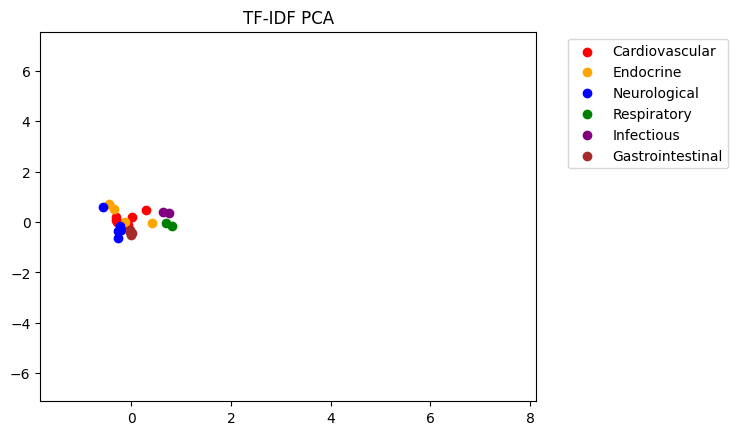

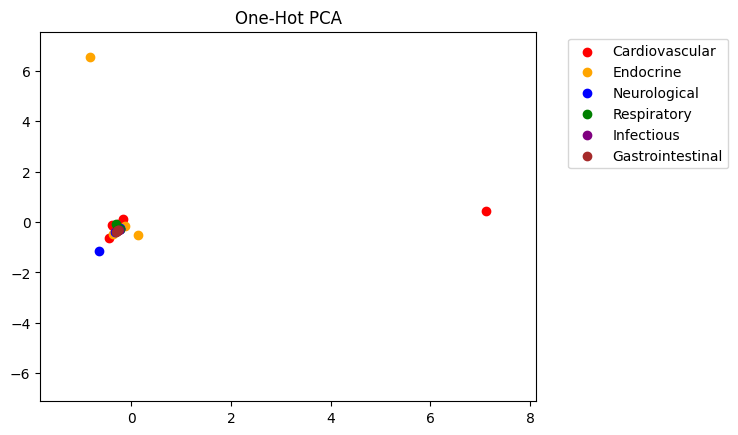

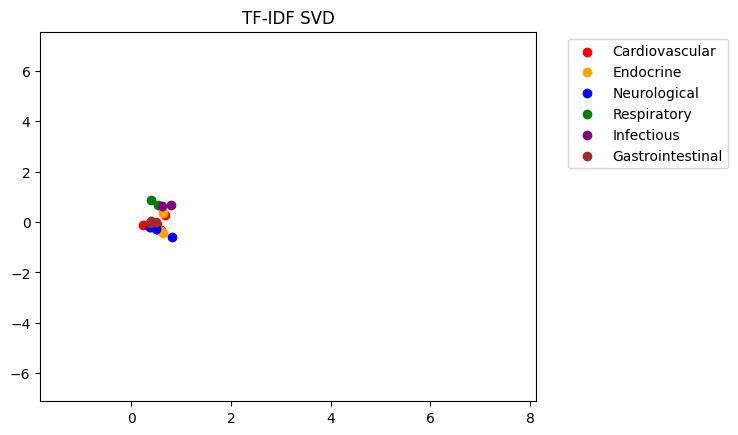

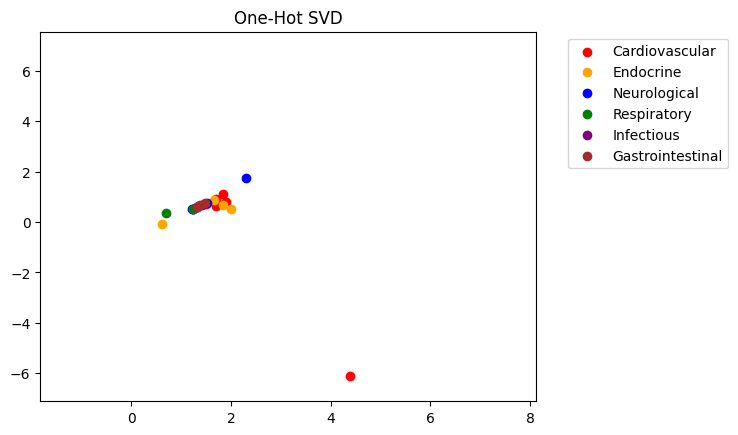

In [5]:
# Define mapping for categories and colors
category_map = {
    'Acute Coronary Syndrome': 'Cardiovascular', 
    'Aortic Dissection': 'Cardiovascular', 
    'Atrial Fibrillation': 'Cardiovascular',
    'Cardiomyopathy': 'Cardiovascular', 
    'Heart Failure': 'Cardiovascular', 
    'Hyperlipidemia': 'Cardiovascular',
    'Hypertension': 'Cardiovascular', 
    'Pulmonary Embolism': 'Cardiovascular', 
    'Adrenal Insufficiency': 'Endocrine',
    'Diabetes': 'Endocrine', 
    'Pituitary Disease': 'Endocrine', 
    'Thyroid Disease': 'Endocrine',
    'Alzheimer': 'Neurological', 
    'Epilepsy': 'Neurological', 
    'Migraine': 'Neurological',
    'Multiple Sclerosis': 'Neurological', 
    'Stroke': 'Neurological', 
    'Asthma': 'Respiratory', 
    'COPD': 'Respiratory',
    'Pneumonia': 'Infectious', 
    'Tuberculosis': 'Infectious', 
    'Gastritis': 'Gastrointestinal',
    'Gastro-oesophageal Reflux Disease': 'Gastrointestinal', 
    'Peptic Ulcer Disease': 'Gastrointestinal',
    'Upper Gastrointestinal Bleeding': 'Gastrointestinal'
}
categories = features_df['Disease'].map(category_map)
color_map = {
    'Cardiovascular': 'red', 
    'Endocrine': 'orange', 
    'Neurological': 'blue',
    'Respiratory': 'green', 
    'Infectious': 'purple', 
    'Gastrointestinal': 'brown'
}

# Define a function to plot scatter plots
def plot_scatter(X, title, xlim=None, ylim=None):
    fig, ax = plt.subplots()
    for cat, color in color_map.items():
        idx = categories == cat
        ax.scatter(X[idx, 0], X[idx, 1], label=cat, color=color)
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    return fig

# Determine global x and y limits for consistency
all_x = np.concatenate([X_pca_tfidf[:,0], X_pca_onehot[:,0], X_svd_tfidf[:,0], X_svd_onehot[:,0]])
all_y = np.concatenate([X_pca_tfidf[:,1], X_pca_onehot[:,1], X_svd_tfidf[:,1], X_svd_onehot[:,1]])
xlim = (all_x.min() - 1, all_x.max() + 1)
ylim = (all_y.min() - 1, all_y.max() + 1)

# Plot PCA
fig1 = plot_scatter(X_pca_tfidf, "TF-IDF PCA", xlim, ylim)
fig2 = plot_scatter(X_pca_onehot, "One-Hot PCA", xlim, ylim)
fig1.show(), fig2.show()

# Plot SVD
fig3 = plot_scatter(X_svd_tfidf, "TF-IDF SVD", xlim, ylim)
fig4 = plot_scatter(X_svd_onehot, "One-Hot SVD", xlim, ylim)
fig3.show(), fig4.show()


## Model Evaluation

In [6]:
# Function for safe cross-validation
def safe_cross_validate(model, X, y, cv):
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    valid_folds = 0
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if len(np.unique(y_test)) < 2:
            continue
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average="macro", zero_division=0))
        recalls.append(recall_score(y_test, y_pred, average="macro", zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, average="macro", zero_division=0))
        valid_folds += 1
    if valid_folds > 0:
        return {
            'accuracy': np.mean(accuracies),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1': np.mean(f1_scores)
        }
    else:
        return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}


## Classification (KNN & Logistic Regression)

Full Data Evaluation:
Accuracy: 0.04


,Rank,Encoding,Model,Accuracy,Precision,Recall,F1-score
20,20,One-Hot,Logistic Regression,1.00,1.000000,1.00,1.000000
10,10,TF-IDF,Logistic Regression,1.00,1.000000,1.00,1.000000
11,11,One-Hot,"KNN (k=3, metric=euclidean)",0.36,0.313333,0.36,0.326667
12,12,One-Hot,"KNN (k=3, metric=manhattan)",0.36,0.313333,0.36,0.326667
15,15,One-Hot,"KNN (k=5, metric=manhattan)",0.28,0.242353,0.28,0.244444
14,14,One-Hot,"KNN (k=5, metric=euclidean)",0.28,0.242222,0.28,0.244211
17,17,One-Hot,"KNN (k=7, metric=euclidean)",0.28,0.242105,0.28,0.244000
18,18,One-Hot,"KNN (k=7, metric=manhattan)",0.28,0.242105,0.28,0.244000
13,13,One-Hot,"KNN (k=3, metric=cosine)",0.32,0.183333,0.32,0.214667
16,16,One-Hot,"KNN (k=5, metric=cosine)",0.24,0.094444,0.24,0.124000


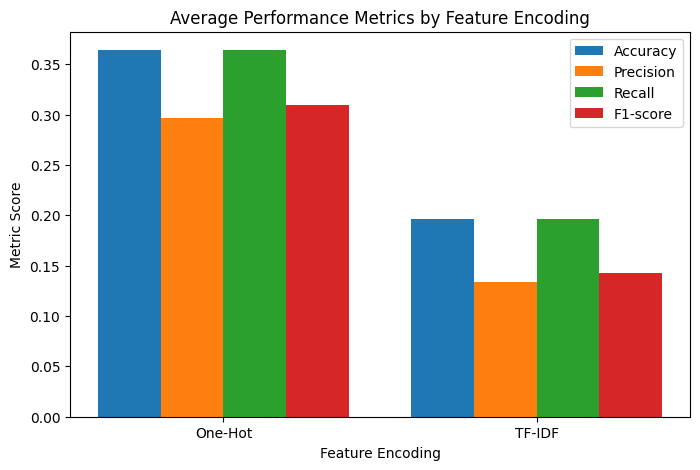

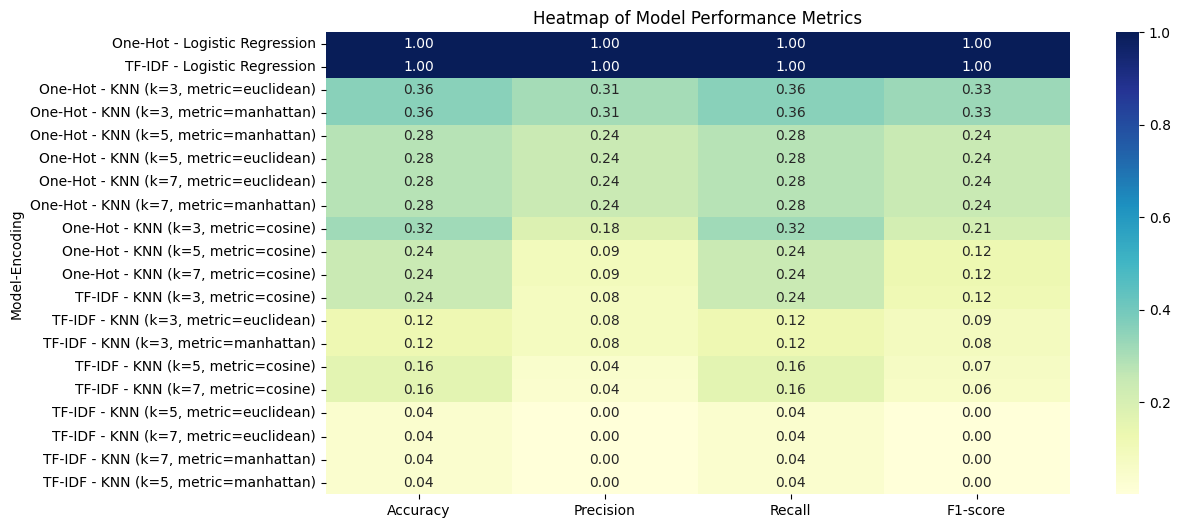

In [7]:
# Normalize feature matrices
scaler = StandardScaler()
tfidf_dense_norm = scaler.fit_transform(tfidf_dense)
onehot_dense_norm = scaler.fit_transform(onehot_dense)

# For demonstration, run a sample evaluation on a selected configuration:
selected_feature = 'TF-IDF'  # or change to 'One-Hot'
selected_model = "KNN"         # Change to "Logistic Regression" if preferred
X_selected = tfidf_dense_norm if selected_feature == "TF-IDF" else onehot_dense_norm

# For KNN, specify parameters
selected_k = 5
selected_metric = 'euclidean'

# Determine cross-validation folds based on minimum samples per class
label_counts = pd.Series(y_encoded).value_counts()
min_samples = label_counts.min()
desired_folds = 5
n_folds = min(desired_folds, min_samples)

if n_folds < 2:
    # Fallback to full evaluation if cross-validation is not possible
    if selected_model == "KNN":
        model = KNeighborsClassifier(n_neighbors=selected_k, metric=selected_metric)
    else:
        model = LogisticRegression(max_iter=1000)
    model.fit(X_selected, y_encoded)
    y_pred = model.predict(X_selected)
    print("Full Data Evaluation:")
    print("Accuracy:", accuracy_score(y_encoded, y_pred))
else:
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    if selected_model == "KNN":
        model = KNeighborsClassifier(n_neighbors=selected_k, metric=selected_metric)
    else:
        model = LogisticRegression(max_iter=1000)
    cv_res = safe_cross_validate(model, X_selected, y_encoded, cv)
    print("Cross-Validation Evaluation:")
    print(cv_res)

# Comprehensive evaluation across multiple configurations (for visualizations)
all_results = []
for encoding, X in [('TF-IDF', tfidf_dense_norm), ('One-Hot', onehot_dense_norm)]:
    for k in [3, 5, 7]:
        for metric in ['euclidean', 'manhattan', 'cosine']:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X, y_encoded)
            y_pred = knn.predict(X)
            all_results.append({
                'Encoding': encoding,
                'Model': f'KNN (k={k}, metric={metric})',
                'Accuracy': accuracy_score(y_encoded, y_pred),
                'Precision': precision_score(y_encoded, y_pred, average="macro", zero_division=0),
                'Recall': recall_score(y_encoded, y_pred, average="macro", zero_division=0),
                'F1-score': f1_score(y_encoded, y_pred, average="macro", zero_division=0)
            })
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X, y_encoded)
    y_pred = lr.predict(X)
    all_results.append({
        'Encoding': encoding,
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_encoded, y_pred),
        'Precision': precision_score(y_encoded, y_pred, average="macro", zero_division=0),
        'Recall': recall_score(y_encoded, y_pred, average="macro", zero_division=0),
        'F1-score': f1_score(y_encoded, y_pred, average="macro", zero_division=0)
    })

results_df_full = pd.DataFrame(all_results)
results_df_full.sort_values(by='F1-score', ascending=False, inplace=True)
results_df_full.index = results_df_full.index + 1
results_df_full.insert(0, 'Rank', results_df_full.index)
display(results_df_full)

# Visualizations: Bar Charts & Heatmap
avg_metrics = results_df_full.groupby("Encoding")[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean().reset_index()
fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
bar_width = 0.2
x = np.arange(len(avg_metrics['Encoding']))
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-score']):
    ax_bar.bar(x + i * bar_width, avg_metrics[metric], width=bar_width, label=metric)
ax_bar.set_xticks(x + bar_width * 1.5)
ax_bar.set_xticklabels(avg_metrics['Encoding'])
ax_bar.set_xlabel("Feature Encoding")
ax_bar.set_ylabel("Metric Score")
ax_bar.set_title("Average Performance Metrics by Feature Encoding")
ax_bar.legend()
plt.show()

heatmap_data = results_df_full[['Model', 'Encoding', 'Accuracy', 'Precision', 'Recall', 'F1-score']].copy()
heatmap_data['Model-Encoding'] = heatmap_data['Encoding'] + " - " + heatmap_data['Model']
heatmap_data.set_index('Model-Encoding', inplace=True)
heatmap_data = heatmap_data[['Accuracy', 'Precision', 'Recall', 'F1-score']]
fig_heat, ax_heat = plt.subplots(figsize=(12, max(6, len(heatmap_data) * 0.3)))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax_heat)
ax_heat.set_title("Heatmap of Model Performance Metrics")
plt.show()


In [8]:
# Disease Predictor Section
# The predictor uses the TF-IDF feature set to transform new patient input.
risk_input = input("Enter Risk Factors: ")
symptoms_input = input("Enter Symptoms: ")
signs_input = input("Enter Signs: ")

# For prediction, transform new input text
new_risk = tfidf_risk.transform([risk_input])
new_symptoms = tfidf_sym.transform([symptoms_input])
new_signs = tfidf_sign.transform([signs_input])
new_tfidf = sparse.hstack([new_risk, new_symptoms, new_signs])
new_tfidf_dense = new_tfidf.toarray()

tfidf_scaler = StandardScaler().fit(tfidf_dense)
new_tfidf_norm = tfidf_scaler.transform(new_tfidf_dense)

# Choose prediction model (adjust parameters as needed)
pred_model_choice = "KNN"  # or "Logistic Regression"
if pred_model_choice == "KNN":
    predictor = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
else:
    predictor = LogisticRegression(max_iter=1000)

# Train predictor on the entire normalized TF-IDF training set
predictor.fit(tfidf_dense_norm, y_encoded)
pred_encoded = predictor.predict(new_tfidf_norm)
predicted_disease = label_encoder.inverse_transform(pred_encoded)
print("Predicted Disease:", predicted_disease[0])


Predicted Disease: Acute Coronary Syndrome
